# Asynchronous Initialization 

#### RTM Cell

$\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$

$\beta_{n} = 0.5*e^{-(v+57)/40}$

$\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$

$\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$

$\alpha_{h} = 0.128*e^{-(v+50)/18}$

$\beta_{h} = 4./(1+e^{-(v+27)/5})$

In [1]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =30

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Initialize "frozen noise" for current clamp and RTM synapse strength

In [2]:
i_ext= np.random.rand(n_E,1)*0.1+0.25

#create array of start times for heterogeneous initialization
start = np.random.rand(n_E,1)* 25 # array of 30 with times from 0 to 25
print(i_ext)

[[0.26597917]
 [0.26615005]
 [0.32535413]
 [0.27760886]
 [0.29571825]
 [0.32092759]
 [0.2624585 ]
 [0.32149429]
 [0.27479643]
 [0.27465831]
 [0.28811607]
 [0.34098893]
 [0.33775092]
 [0.2700904 ]
 [0.31100159]
 [0.33725846]
 [0.31573449]
 [0.2659178 ]
 [0.30783717]
 [0.26808362]
 [0.33835957]
 [0.27167878]
 [0.28903146]
 [0.28934433]
 [0.2808522 ]
 [0.31990319]
 [0.25288032]
 [0.28073611]
 [0.31280102]
 [0.29830365]]


Add excitatory connection from each RTM cell to every other RTM cell in the network and save

In [3]:
# add 1 synaptic connection from each cell to every other cell avoiding self connections
def like2like(source, target):
    """A simple function for setting # of synaptic connections based on pop-name attribute. """
    if source['node_id'] == target['node_id']:
        # No autapses
        return 0

    # 1 connection otherwise
    return 1


def rand_syn_weight(source, target, min_weight, max_weight):
    sec_x=0.5
    sec_id=0
    return np.random.uniform(min_weight, max_weight), sec_x, sec_id


conn = net.add_edges(source={'pop_name': 'Exc'}, target={'pop_name': 'Exc'},
              connection_rule=like2like, # Note that we are passing in the function name but not calling it
              connection_params={},
              target_sections=['soma'],
              dynamics_params='PING_ExcToExc.json',     
              model_template='exp2syn',
              delay=0)

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.00625, 'max_weight': 0.00825},
                    dtypes=[np.float, np.uint, np.uint])




Build and save connections

In [4]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [5]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=30,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [6]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   connection_rule=one_each,
                   syn_weight=0.1,               
                   delay=0,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150],
                   dynamics_params='PING_ExcToExc.json',
                   model_template='exp2syn')

In [7]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

We now need to create an initial spike for each of our cells with varying phase

In [8]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=start[i])
spikes.to_sonata('input/Asynchronous.h5')

In [9]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=start[i])
spikes.to_sonata('input/Asynchronous.h5')

In [10]:
from bmtk.utils.reports.spike_trains.spike_train_readers import SonataSTReader as Sonata

spikes=Sonata("input/Asynchronous.h5")
spikes.n_spikes(population="extnet")
spikes.get_times(node_id=4, population="extnet")

array([15.67201096])

The RTM neurons also have a current clamp input that was defined earlier in our "frozen noise"

In [11]:
import h5py


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Building the Simulation Environment

In [12]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=200.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/Asynchronous.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

### Running the Simulation

In [13]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-01-27 23:48:29,979 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-01-27 23:48:30,148 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-01-27 23:48:30,207 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-01-27 23:48:31,335 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2021-01-27 23:48:31,434 [INFO] Running simulation for 200.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 200.000 ms with the time step 0.100 ms


2021-01-27 23:48:31,467 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-01-27 23:48:31,497 [INFO] Block save every 2000 steps


INFO:NEURONIOUtils:Block save every 2000 steps


2021-01-27 23:48:32,717 [INFO]     step:2000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:2000 t_sim:200.00 ms


2021-01-27 23:48:32,769 [INFO] Simulation completed in 1.335 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.335 seconds 


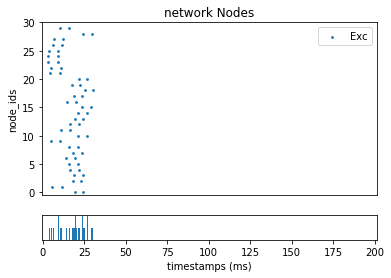

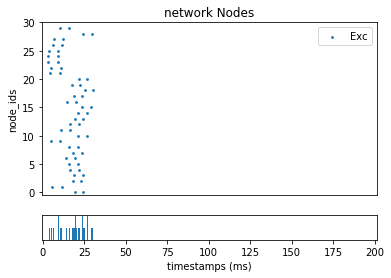

In [15]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='simulation_config.json', group_by='pop_name')

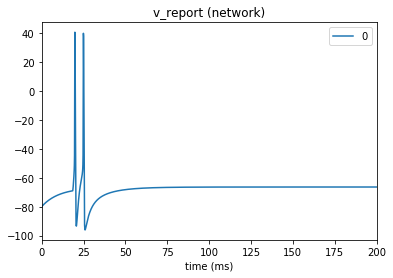

In [16]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='simulation_config.json', node_ids=[0], report_name='v_report')

In [16]:
from bmtk.analyzer.spike_trains import to_dataframe

results_df = to_dataframe(config_file='simulation_config.json')
print('Number of Spikes: {}'.format(len(results_df)))
results_df.head()

Number of Spikes: 360


,node_ids,timestamps,population
0,0,3.5,network
1,20,13.4,network
2,20,10.7,network
3,20,8.3,network
4,20,5.9,network


In [17]:
print(results_df)

     node_ids  timestamps population
0           0         3.5    network
1          20        13.4    network
2          20        10.7    network
3          20         8.3    network
4          20         5.9    network
5          20         3.5    network
6          19        41.7    network
7          19        29.6    network
8          19        26.3    network
9          20        16.5    network
10         19        24.0    network
11         19        19.0    network
12         19        16.5    network
13         19        13.4    network
14         19        10.7    network
15         19         8.3    network
16         19         5.9    network
17         19         3.5    network
18         18        41.7    network
19         19        21.5    network
20         20        19.0    network
21         20        21.5    network
22         20        24.0    network
23         22        10.7    network
24         22         8.3    network
25         22         5.9    network
2